In [1]:
import h5py
import numpy as np
import pickle
import scipy
from scipy.stats import norm
from collections import defaultdict

import matplotlib
from matplotlib import pylab
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.dpi'] = 80
textsize = 'x-large'
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (6, 4),
         'axes.labelsize': textsize,
         'axes.titlesize': textsize,
         'xtick.labelsize': textsize,
         'ytick.labelsize': textsize,
         'figure.facecolor': 'w'}
pylab.rcParams.update(params)
from matplotlib import pyplot as plt

import dynesty
from dynesty import utils as dyfunc
from getdist import plots, MCSamples

%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(1, '../code')
import plotter
import utils
from utils import *

Figures

1. Emulator 3-panel accuracy plot
2. Covariance matrices: a) sample variance; b) emulator performance, c) emulator performance smoothed
3. Contour plots, single model recovery test: a) key cosmology parameters b) key HOD/AB parameters
4. 70-model recovery test: 1/sigma bar charts for individual summary statistics for key deliverable parameters 
5. 70-model recovery test: 1/sigma bar charts for adding in one statistic at a time, for key deliverable parameters 
6. 70-model recovery test: cumulative histogram ((median-truth)/error) for adding in one statistic at a time, compared to unit gaussian, for key cosmo deliverable params
    1. note: need to understand omega_m bias! look at individual statistic plot?
7. Scales analysis, 70 model average: 1/sigma vs. minimum scale; statistics: individual, all-5, all-5-minus-UPF; for key deliverable parameters

Appendix

1. Contour plots, single model recovery test: a) all cosmological parameters; b) all hod parameters; c) key cosmology + key HOD/AB parameters 
2. Contour plot, single model recovery test: for emulator performance & smoothed covariance matrices, key cosmological parameters
3. 70-model recovery test: 1/sigma bar charts for the 3 assembly bias parameters for adding in 1 statistic at a time
    1. q: should include some HOD parameters here? 
    2. q: do we also/instead want the results for the individual statistics, to better tell which are contributing to AB information?

Backup

- Best fit for single test mock, compared to emu truth

# Figures (Main)

## Figure 1. Emulator 3-panel accuracy plot

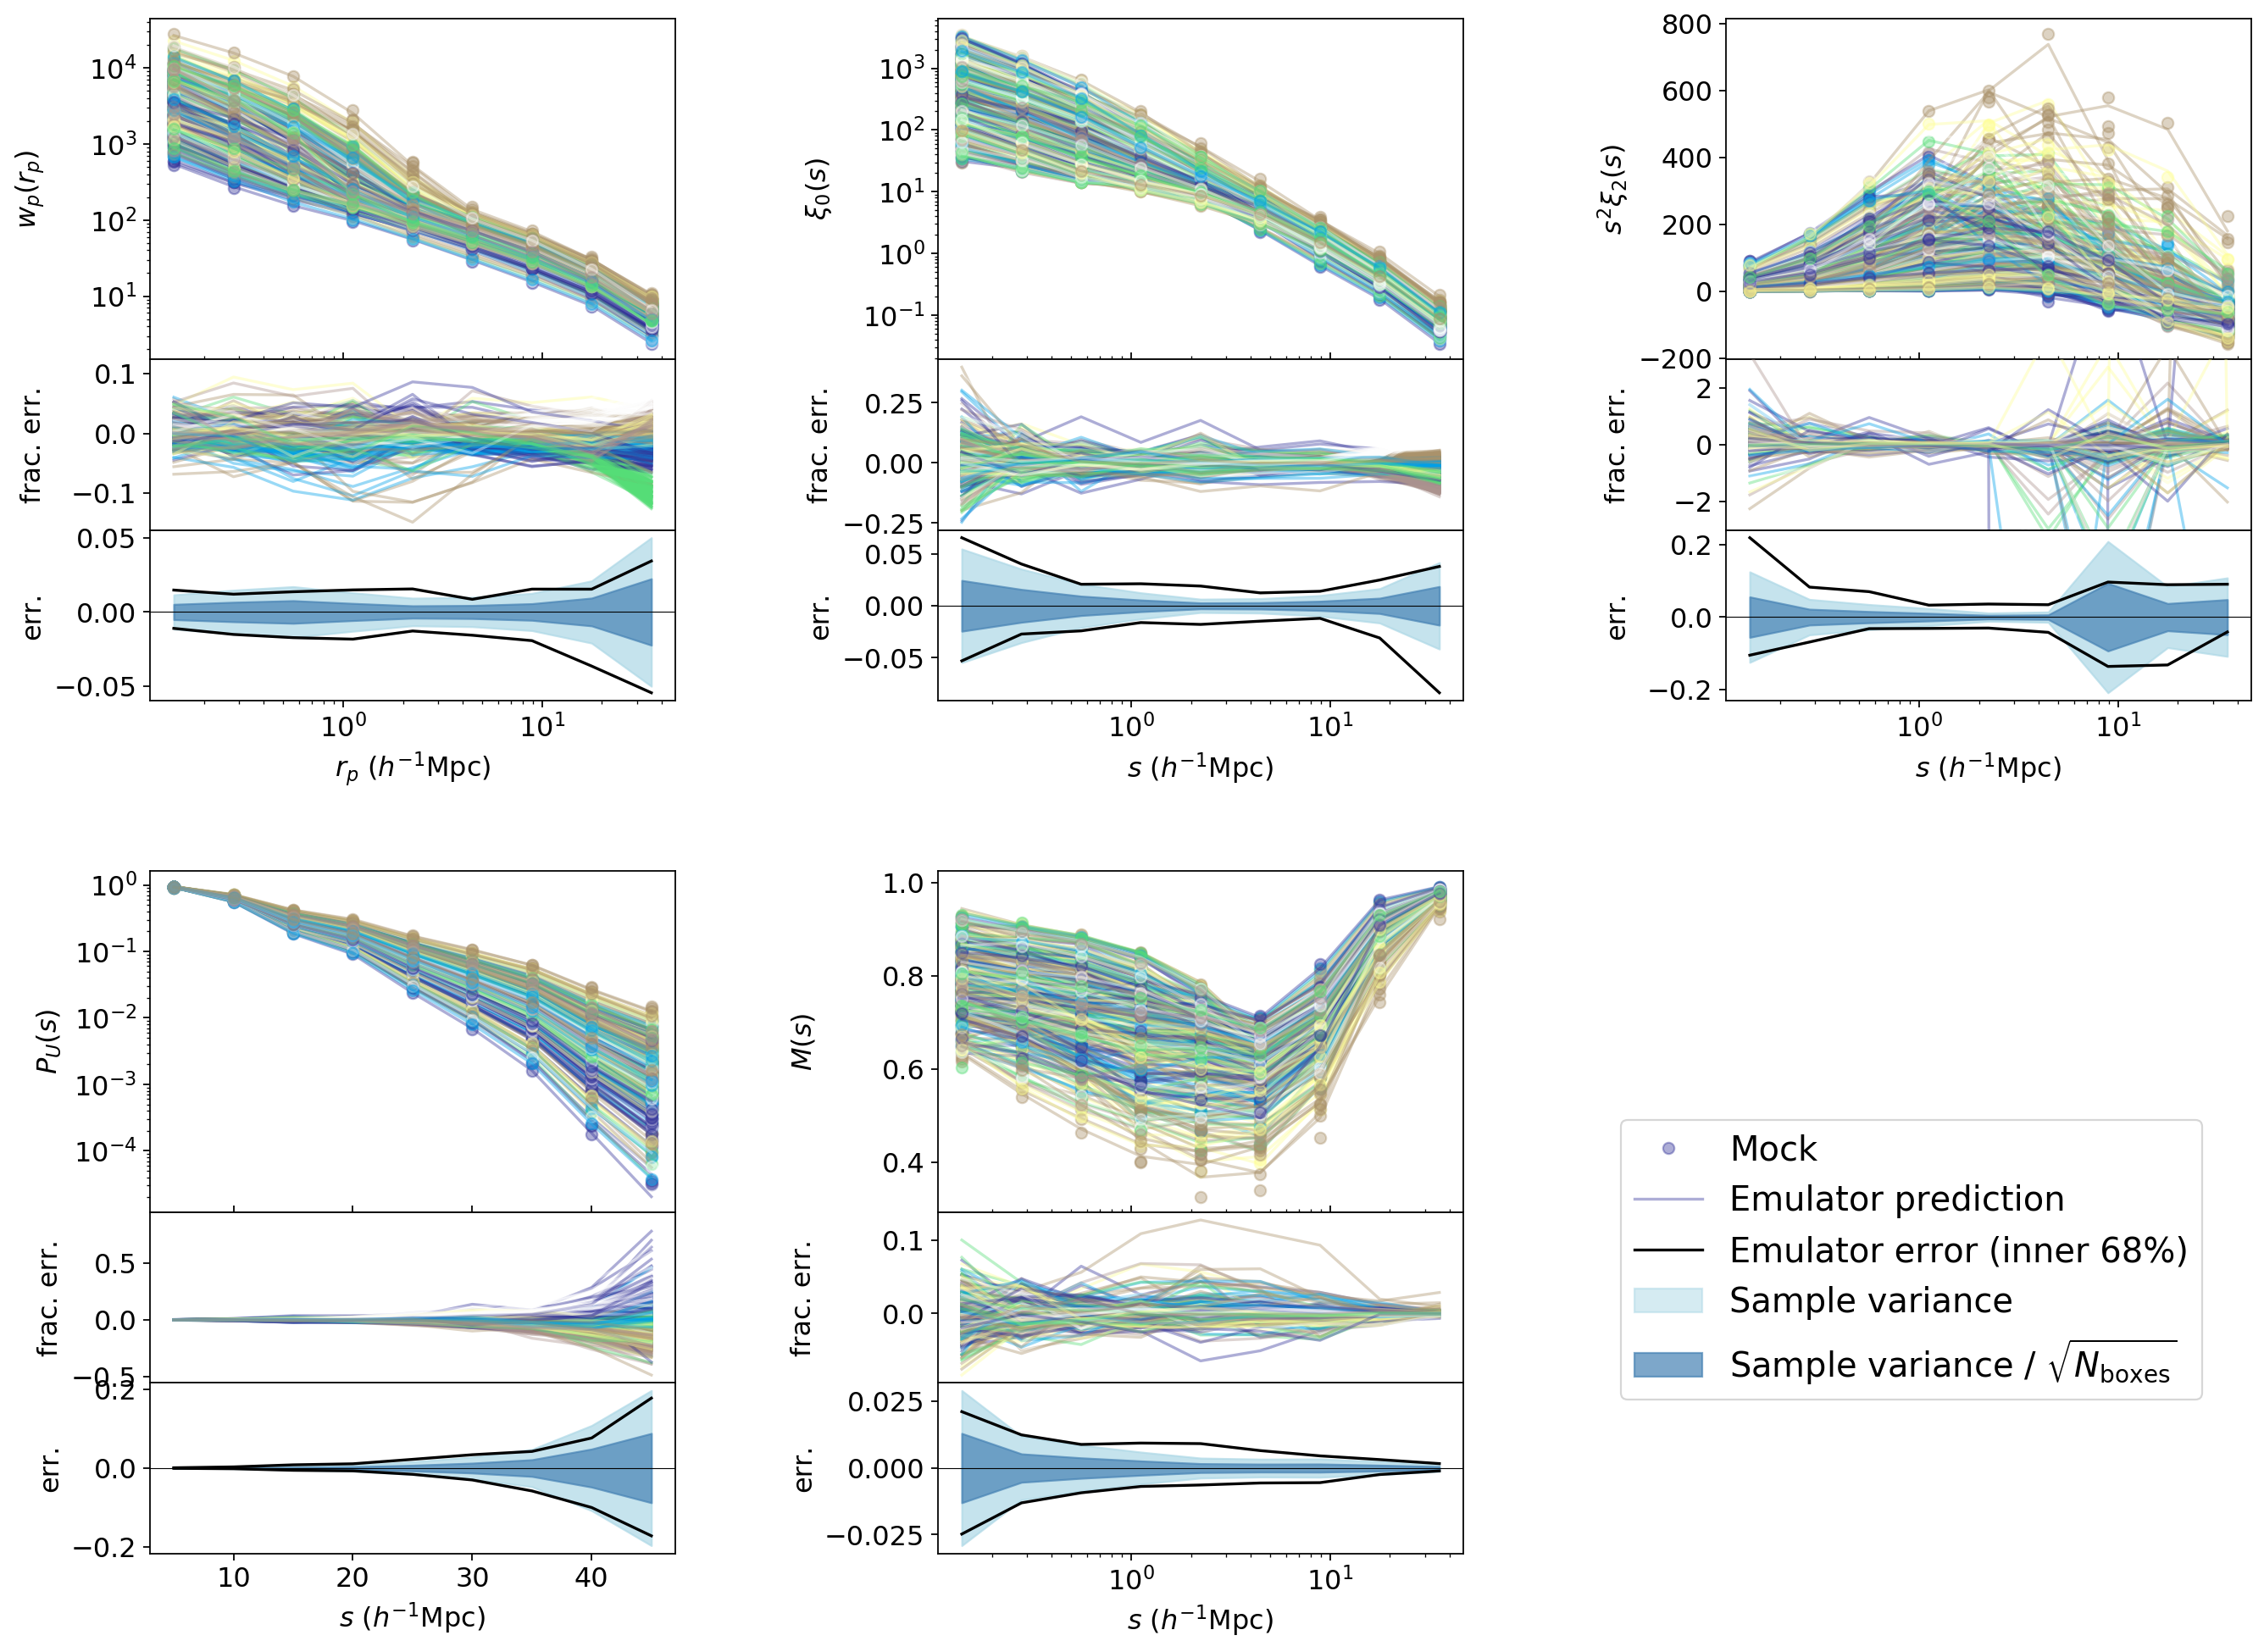

In [8]:
statistics = ['wp', 'xi', 'xi2', 'upf', 'mcf']
train_tags = [f'_{utils.get_fiducial_emu_name(s)}_{utils.get_fiducial_emu_scaling(s)}' for s in statistics]
plotter.plot_accuracy_figure(statistics, train_tags)

### Figure 2. Covariance matrices: a) sample variance; b) emulator performance

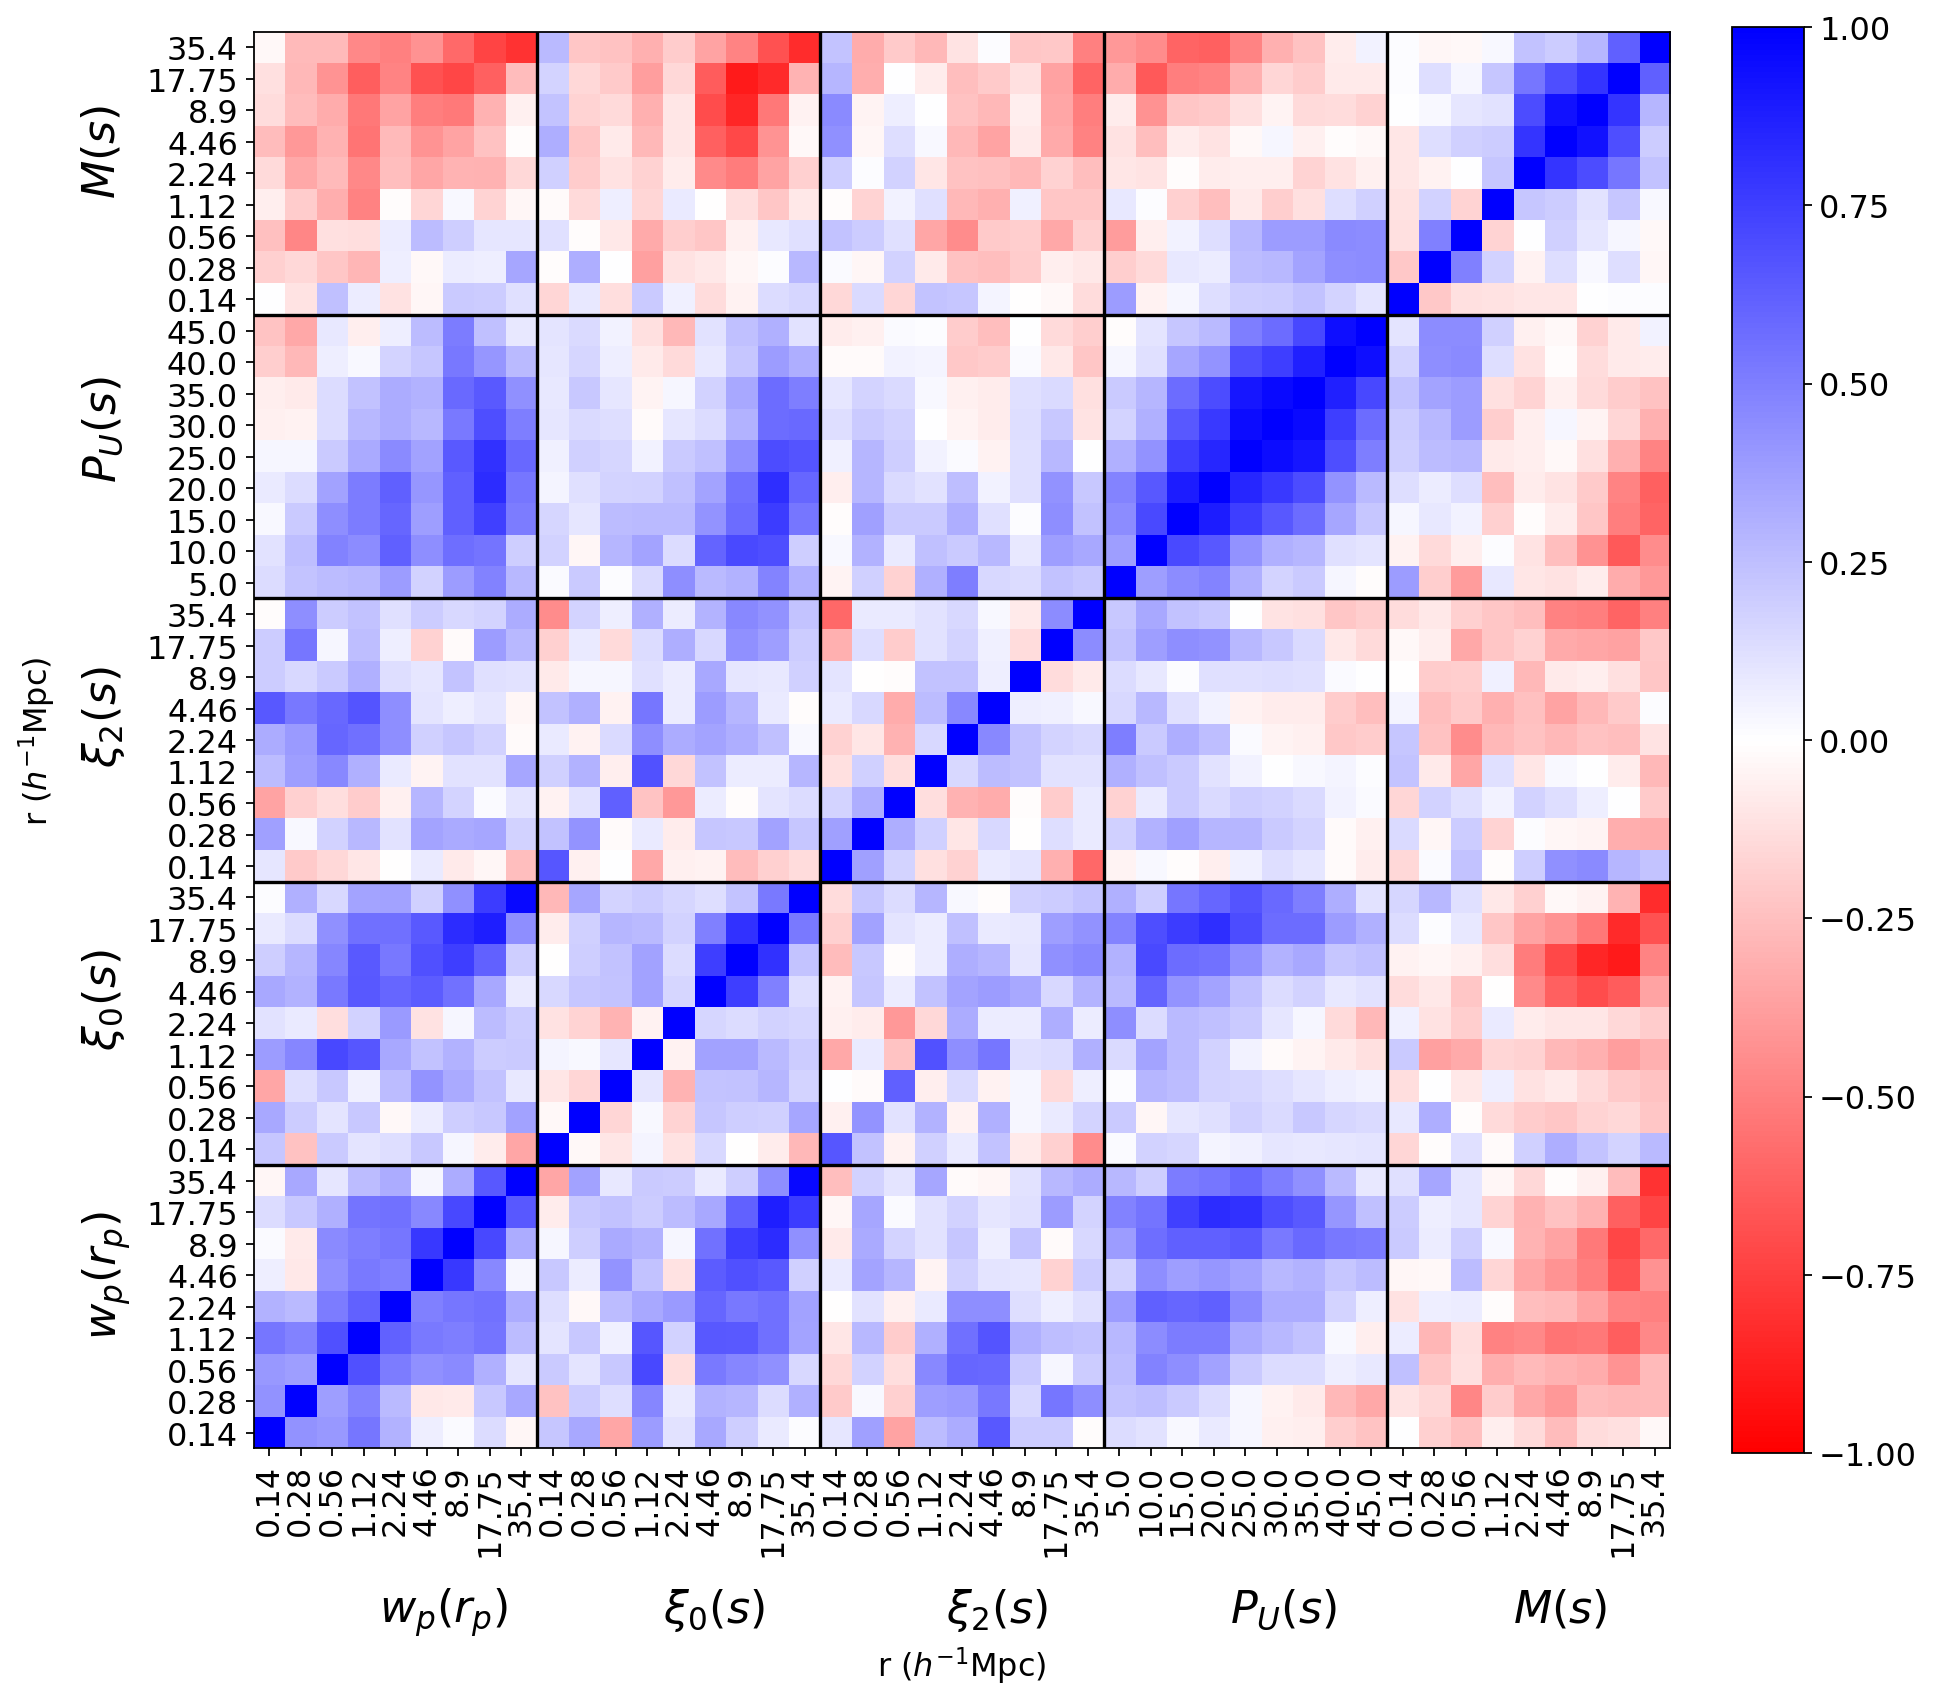

In [11]:
statistics = ['wp', 'xi', 'xi2', 'upf', 'mcf']

cov_tag = 'aemulus'
errtag = '_hod3_test0'

cov_dir = '../covariances'    
stat_str = '_'.join(statistics)
cov_fn = f"{cov_dir}/cov_{cov_tag}_{stat_str}{errtag}.dat"
cov_smooth_fn = f"{cov_dir}/cov_smoothgauss_{cov_tag}_{stat_str}{errtag}.dat"

cov = np.loadtxt(cov_fn)
corr = utils.reduced_covariance(cov)
plotter.plot_correlation_matrix(corr, statistics)

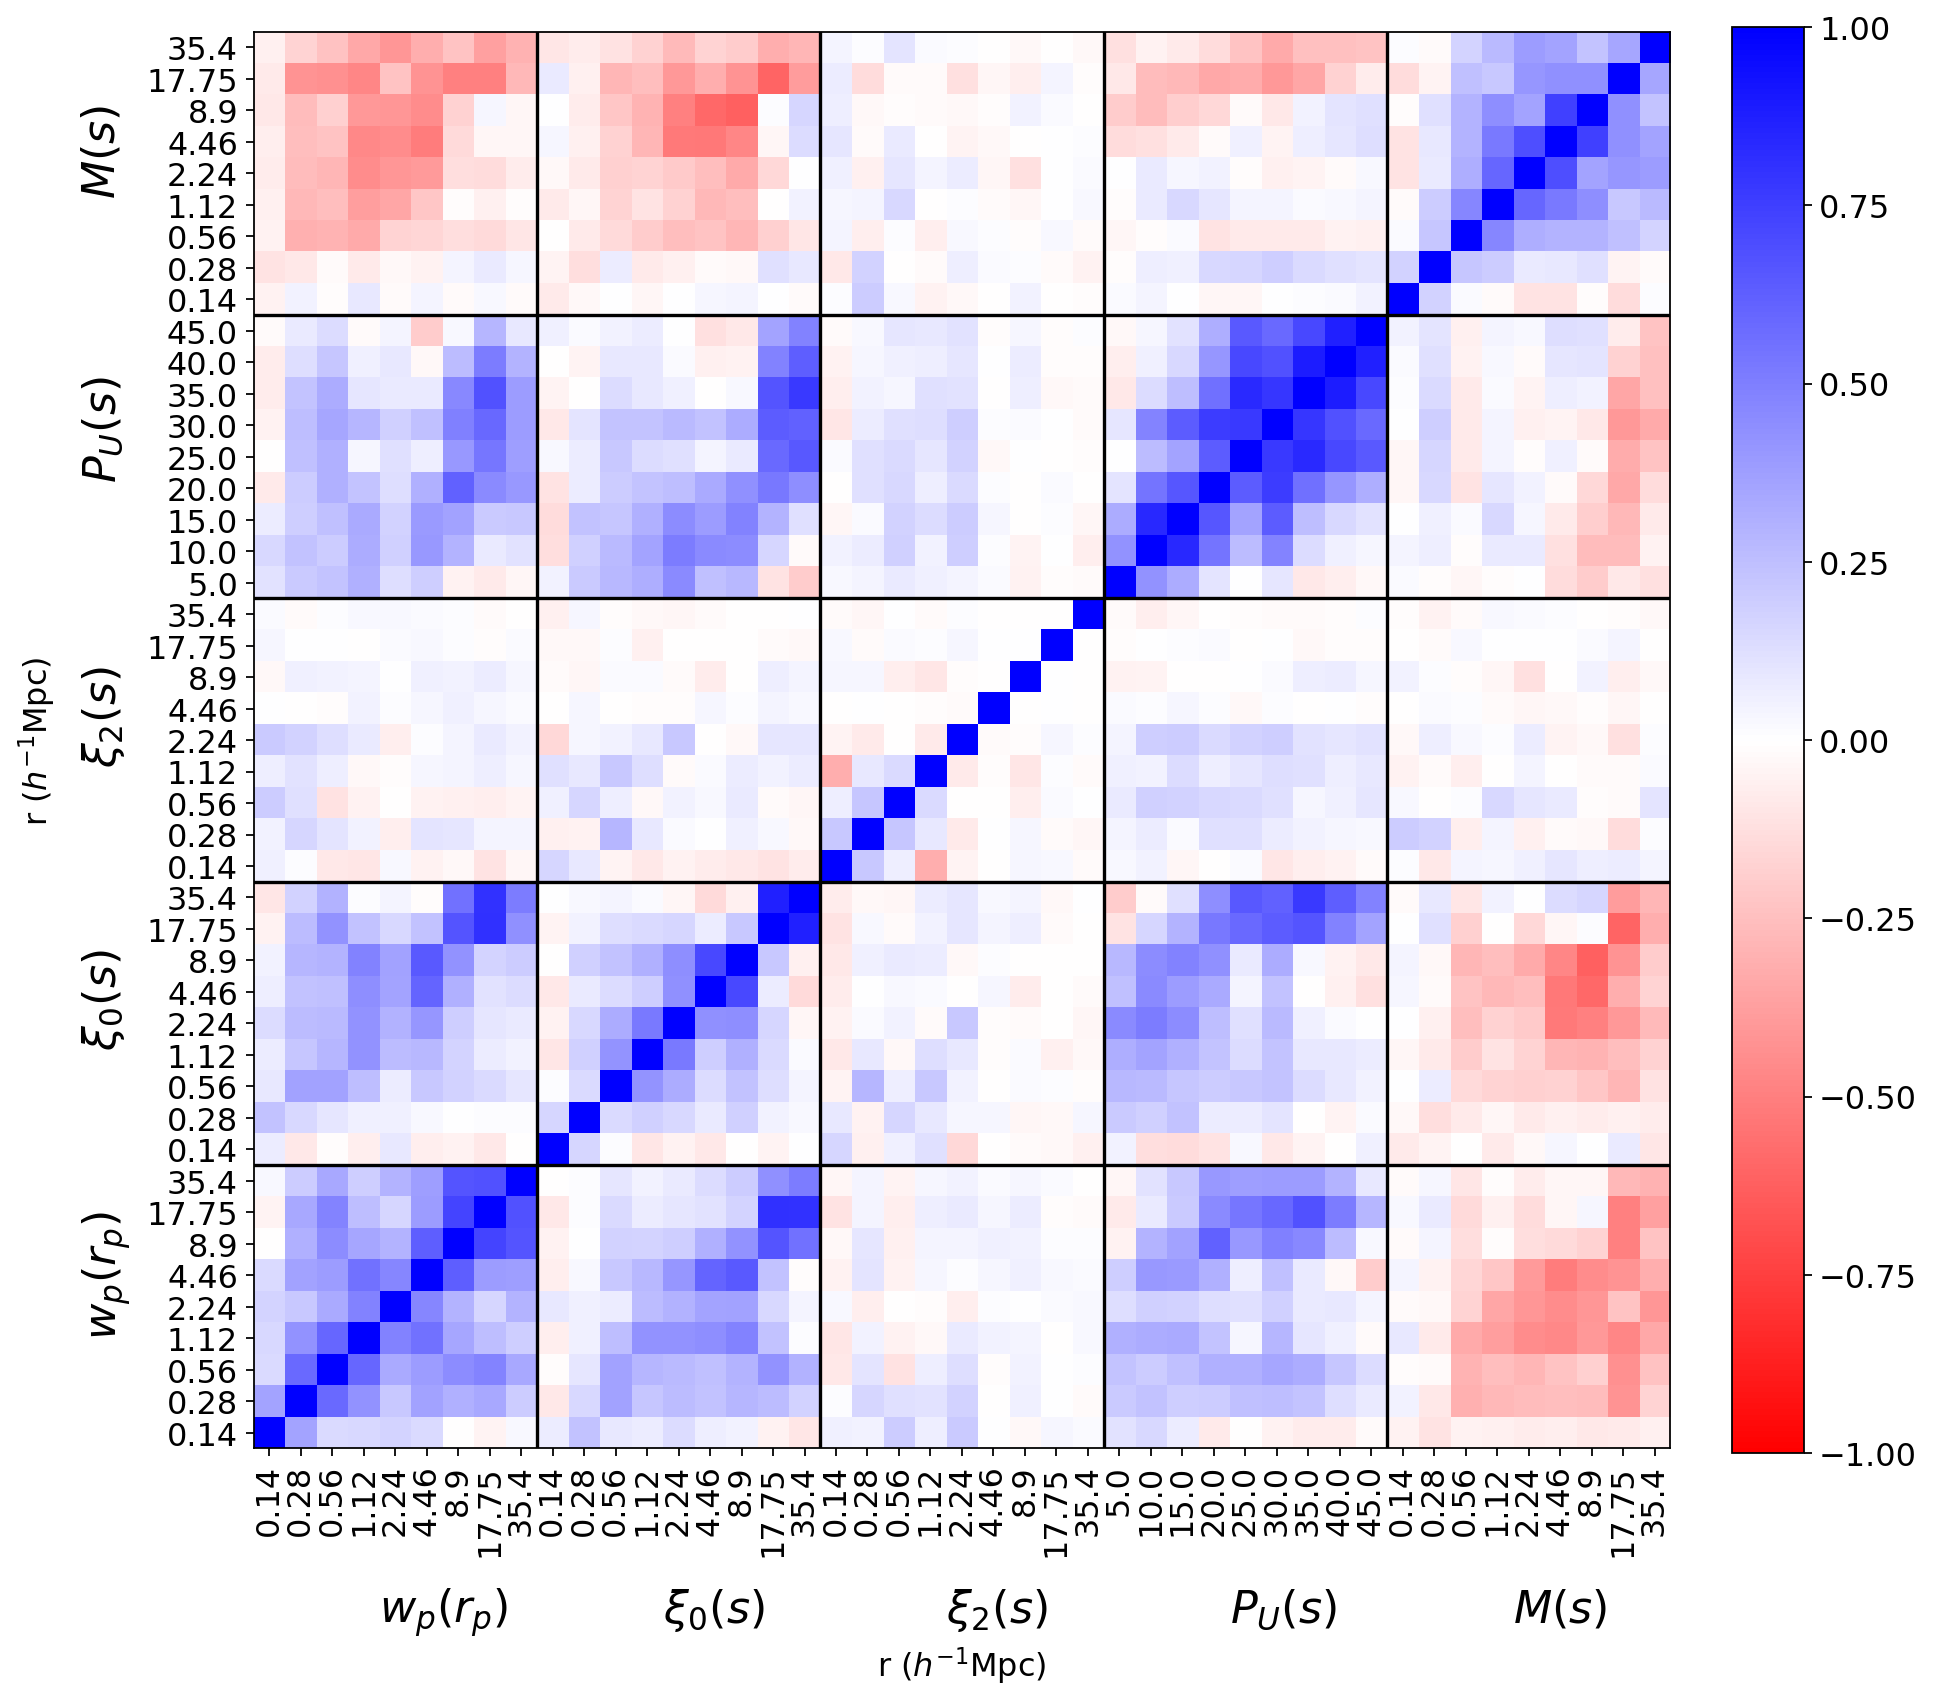

In [12]:
statistics = ['wp', 'xi', 'xi2', 'upf', 'mcf']

cov_tag = 'emuperf'
errtag = '_hod3_test0'

cov_dir = '../covariances'    
stat_str = '_'.join(statistics)
cov_fn = f"{cov_dir}/cov_{cov_tag}_{stat_str}{errtag}.dat"
cov_smooth_fn = f"{cov_dir}/cov_smoothgauss_{cov_tag}_{stat_str}{errtag}.dat"

cov = np.loadtxt(cov_fn)
corr = utils.reduced_covariance(cov)
plotter.plot_correlation_matrix(corr, statistics)

### Figure 3. Contour plots, single model recovery test: a) key cosmology parameters b) key HOD/AB parameters

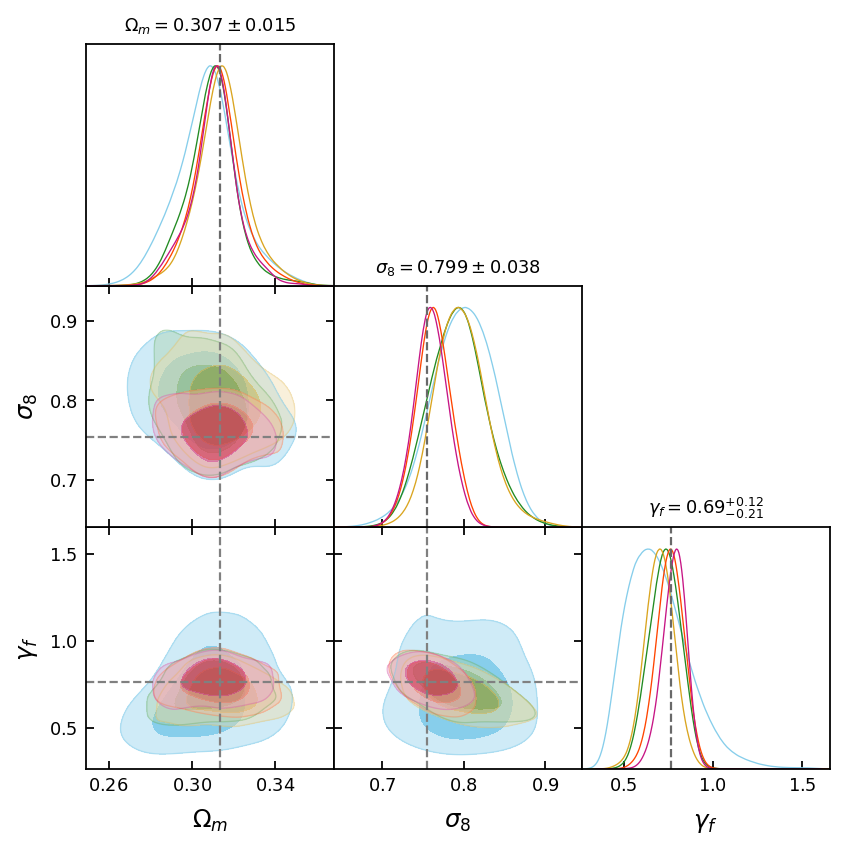

In [14]:
chaintags = [
             'wp_c1h12_all',
             'wp_xi_c1h12_all',
             'wp_xi_xi2_c1h12_all',
             'wp_xi_xi2_upf_c1h12_all',
             'wp_xi_xi2_upf_mcf_c1h12_all',
            ]
legend_labels = [
                 make_label('wp'),
                 make_label(['wp', 'xi']),
                 make_label(['wp', 'xi', 'xi2']),
                 make_label(['wp', 'xi', 'xi2', 'upf']),
                 make_label(['wp', 'xi', 'xi2', 'upf', 'mcf']),
                ]
colors = ['skyblue',
          'forestgreen',
          'goldenrod',
          'orangered',
          'mediumvioletred'
         ]
g = plotter.plot_contours(chaintags, legend_labels=[],
                          colors=colors, legend_loc='upper right',
                          params_toplot=['Omega_m', 'sigma_8', 'f'])

In [15]:
chaintags = [
             'wp_c1h12_all',
             'wp_xi_c1h12_all',
             'wp_xi_xi2_c1h12_all',
             'wp_xi_xi2_upf_c1h12_all',
             'wp_xi_xi2_upf_mcf_c1h12_all',
            ]
legend_labels = [
                 make_label('wp'),
                 make_label(['wp', 'xi']),
                 make_label(['wp', 'xi', 'xi2']),
                 make_label(['wp', 'xi', 'xi2', 'upf']),
                 make_label(['wp', 'xi', 'xi2', 'upf', 'mcf']),
                ]
colors = ['skyblue',
          'forestgreen',
          'goldenrod',
          'orangered',
          'mediumvioletred'
         ]
g = plotter.plot_contours(chaintags, legend_labels=[],
                          colors=colors, legend_loc='upper right',
                          params_toplot=['M_sat', 'v_bs', 'f_env'])

Figure 4 preliminaries:

In [10]:
chaintag_prior = 'prior'
prior_dict = construct_results_dict(chaintag_prior)

In [11]:
results_dict = defaultdict(dict)

id_pairs = np.loadtxt('../tables/id_pairs_recovery_test_70.txt', delimiter=',', dtype=np.int)

stat_strs = np.loadtxt('../tables/statistic_sets_single.txt', dtype=str)

for stat_str in stat_strs:
    print(stat_str)
    for i, id_pair in enumerate(id_pairs):
        
        id_cosmo, id_hod = id_pair
        chaintag = f'{stat_str}_c{id_cosmo}h{id_hod}_all_minscale0'
        result_dict_single = utils.construct_results_dict(chaintag)
        results_dict[stat_str][tuple(id_pair)] = result_dict_single

wp
xi
xi2
upf
mcf


In [12]:
stat_strs_toplot = ['wp', 'xi', 'xi2', 'upf', 'mcf']
labels = [
         make_label('wp'),
         make_label('xi'),
         make_label('xi2'),
         make_label('upf'),
         make_label('mcf'),
        ]
colors = ['skyblue',
          'forestgreen',
          'orange',
          'red',
          'magenta'
         ]
params_toplot = ['Omega_m', 'sigma_8', 'f', 'fsigma8']

### Figure 4. 70-model recovery test: 1/sigma bar charts for individual summary statistics for key deliverable parameters 

In [6]:
plotter.plot_uncertainty_figure(results_dict, prior_dict, params_toplot, stat_strs_toplot, id_pairs, labels, colors)

Figures 5-6 preliminaries:

In [13]:
id_pairs = np.loadtxt('../tables/id_pairs_recovery_test_70.txt', delimiter=',', dtype=np.int)

stat_strs = np.loadtxt('../tables/statistic_sets_addingin.txt', dtype=str)

for stat_str in stat_strs:
    print(stat_str)
    for i, id_pair in enumerate(id_pairs):
        
        id_cosmo, id_hod = id_pair
        chaintag = f'{stat_str}_c{id_cosmo}h{id_hod}_all_minscale0'
        result_dict_single = utils.construct_results_dict(chaintag)
        results_dict[stat_str][tuple(id_pair)] = result_dict_single

wp_xi
wp_xi_xi2
wp_xi_xi2_upf
wp_xi_xi2_upf_mcf


In [14]:
stat_strs_toplot = ['wp', 'wp_xi', 'wp_xi_xi2', 'wp_xi_xi2_upf', 'wp_xi_xi2_upf_mcf']
labels = [
         make_label('wp'),
         '+'+make_label('xi'),
         '+'+make_label('xi2'),
         '+'+make_label('upf'),
         '+'+make_label('mcf'),
        ]
colors = ['skyblue',
          'forestgreen',
          'goldenrod',
          'orangered',
          'mediumvioletred'
         ]
params_toplot = ['Omega_m', 'sigma_8', 'f', 'fsigma8']

### Figure 5. 70-model recovery test: 1/sigma bar charts for adding in one statistic at a time, for key deliverable parameters 

In [11]:
plotter.plot_uncertainty_figure(results_dict, prior_dict, params_toplot, stat_strs_toplot, 
                                id_pairs, labels, colors)

### Figure 6. 70-model recovery test: cumulative histogram ((median-truth)/error) for adding in one statistic at a time, compared to unit gaussian, for key cosmo deliverable params

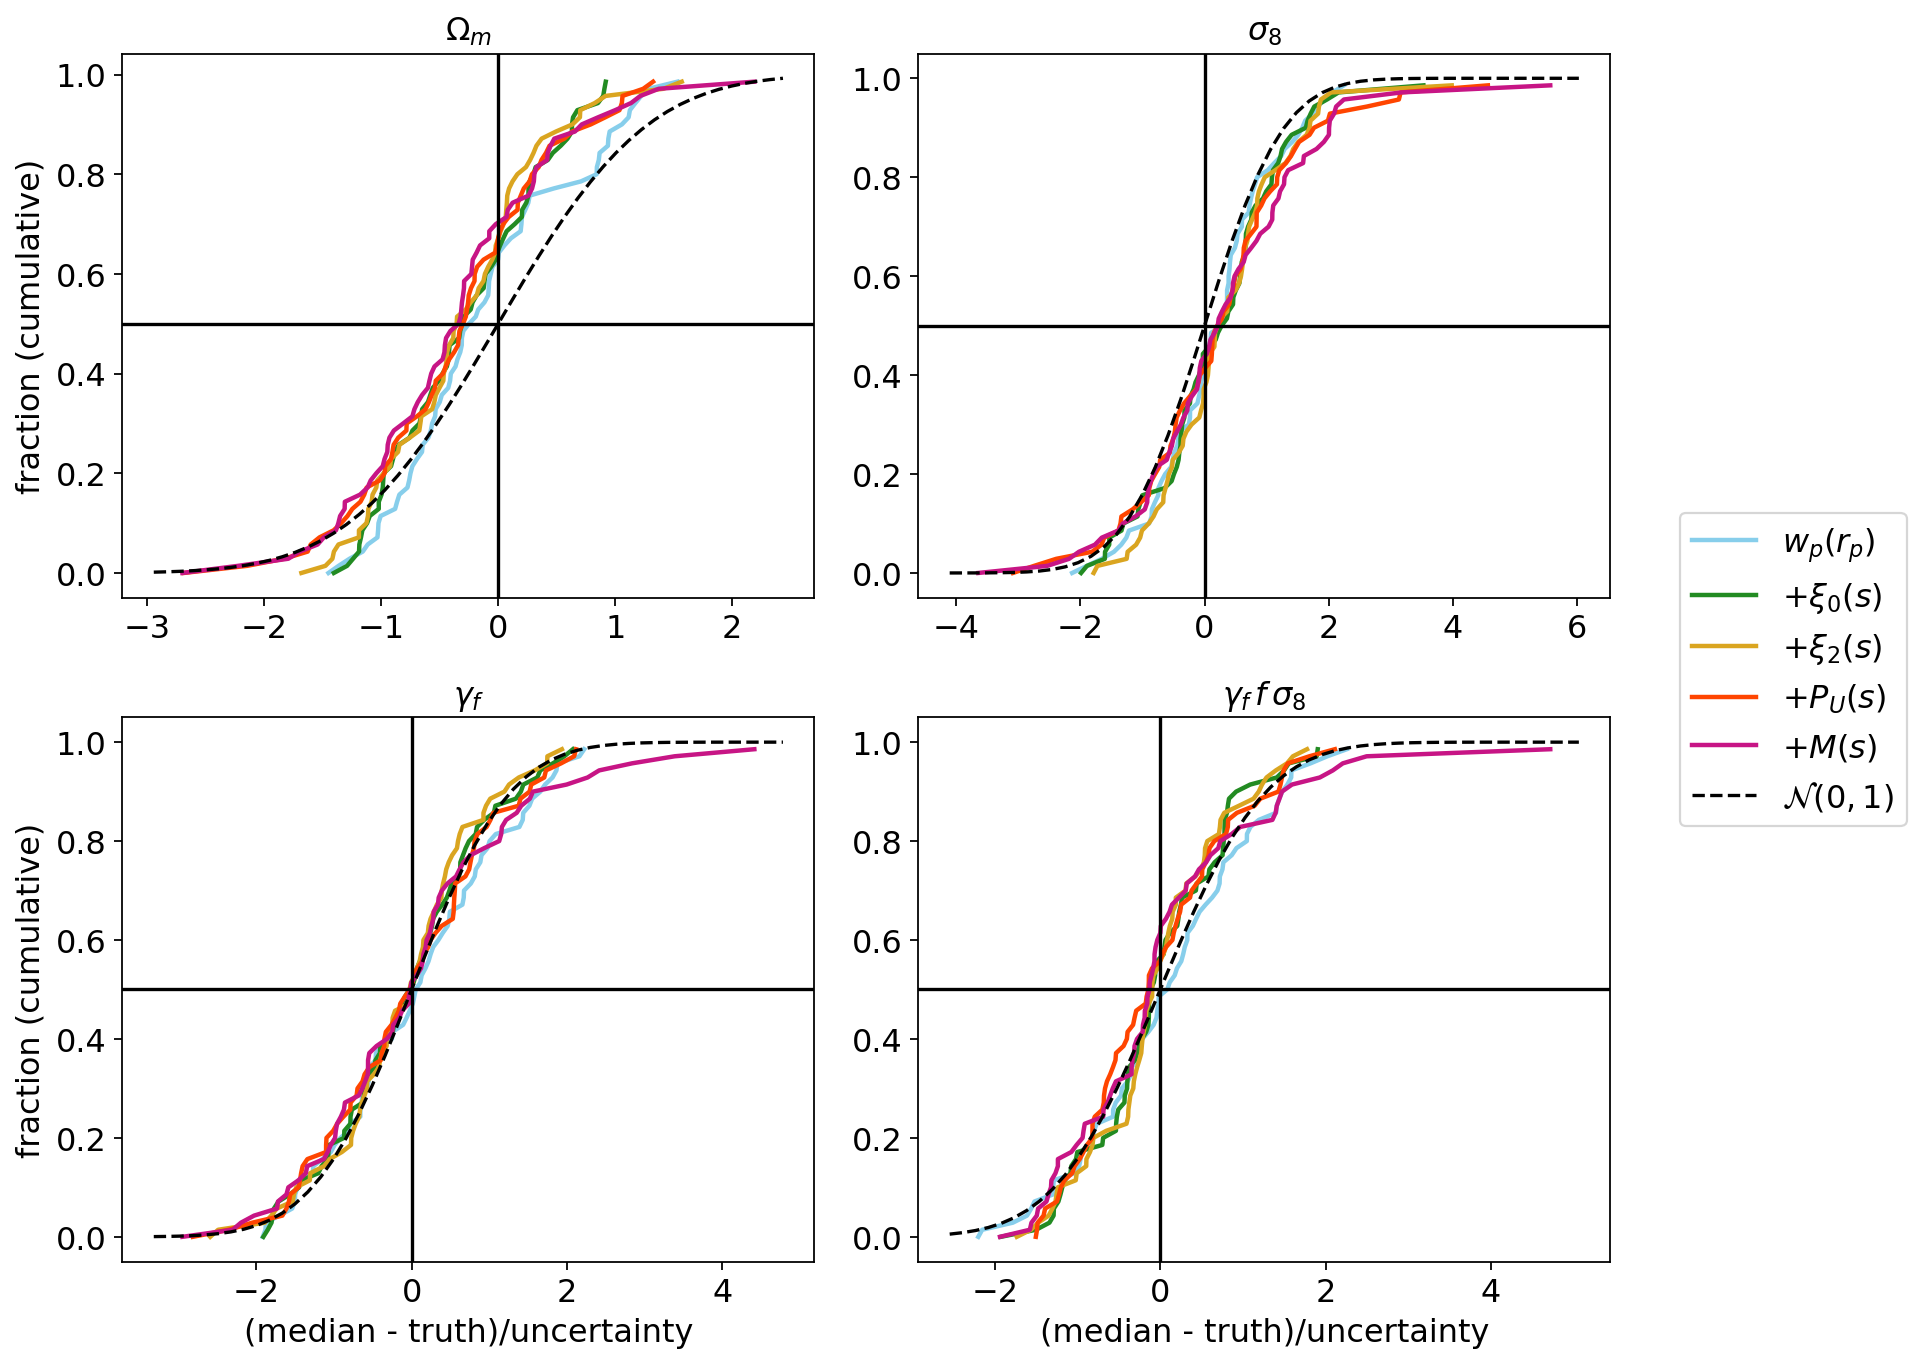

In [18]:
plotter.plot_cumulative_dist_figure(results_dict, params_toplot, stat_strs_toplot, id_pairs, labels, colors, divide_by_error=True)

Scale dependence figure preliminaries

In [31]:
#id_pairs = [(1,12), (1,13)]
id_pairs = np.loadtxt('../tables/id_pairs_recovery_test_70.txt', delimiter=',', dtype=np.int)
stat_strs = np.loadtxt('../tables/statistic_sets_single.txt', dtype=str)
stat_strs = np.concatenate((stat_strs, ['wp_xi_xi2_mcf', 'wp_xi_xi2_upf_mcf']))

In [32]:
results_dicts_minscales = defaultdict(dict)
min_scales = np.arange(0,9)

for min_scale in min_scales:
    
    config_tag = f'_minscale{min_scale}'
    results_dict_m = defaultdict(dict)

    for stat_str in stat_strs:
        
        for i, id_pair in enumerate(id_pairs):

            id_cosmo, id_hod = id_pair

            chaintag = f'{stat_str}_c{id_cosmo}h{id_hod}_all{config_tag}'
            results_dict_m[stat_str][tuple(id_pair)] = utils.construct_results_dict(chaintag)

    results_dicts_minscales[min_scale] = results_dict_m

In [40]:
stat_strs = np.loadtxt('../tables/statistic_sets_single.txt', dtype=str)
stat_strs = np.concatenate((stat_strs, ['wp_xi_xi2_mcf', 'wp_xi_xi2_upf_mcf']))
#stat_strs = np.array(['wp_xi_xi2_mcf'])

results_dicts_maxscales = defaultdict(dict)
max_scales = np.arange(0,9)

for max_scale in max_scales:
    
    config_tag = f'_maxscale{max_scale}'
    results_dict_m = defaultdict(dict)

    for stat_str in stat_strs:

        for i, id_pair in enumerate(id_pairs):

            id_cosmo, id_hod = id_pair

            chaintag = f'{stat_str}_c{id_cosmo}h{id_hod}_all{config_tag}'
            results_dict_m[stat_str][tuple(id_pair)] = utils.construct_results_dict(chaintag)
        
    results_dicts_maxscales[max_scale] = results_dict_m

In [41]:
colors = ['blue',
          'forestgreen',
          'orange',
          'red',
          'magenta',
          'crimson',
          'mediumvioletred'
         ]
labels = [
         make_label('wp'),
         make_label('xi'),
         make_label('xi2'),
         make_label('upf'),
         make_label('mcf'),
         make_label(['wp', 'xi', 'xi2', 'mcf']),
         make_label(['wp', 'xi', 'xi2', 'upf', 'mcf'])
        ]
lws = [2,2,2,2,2,3,3]
long_dash = (0, (5, 10))
lss = ['-', '-.', '--', ':', long_dash, '-.', '-']
params_toplot = ['Omega_m', 'sigma_8', 'f', 'fsigma8']
stat_strs_toplot = stat_strs

### Figure 7. Scales analysis, 70 model average: 1/sigma vs. minimum scale; statistics: individual, all-5, all-5-minus-UPF; for key deliverable parameters

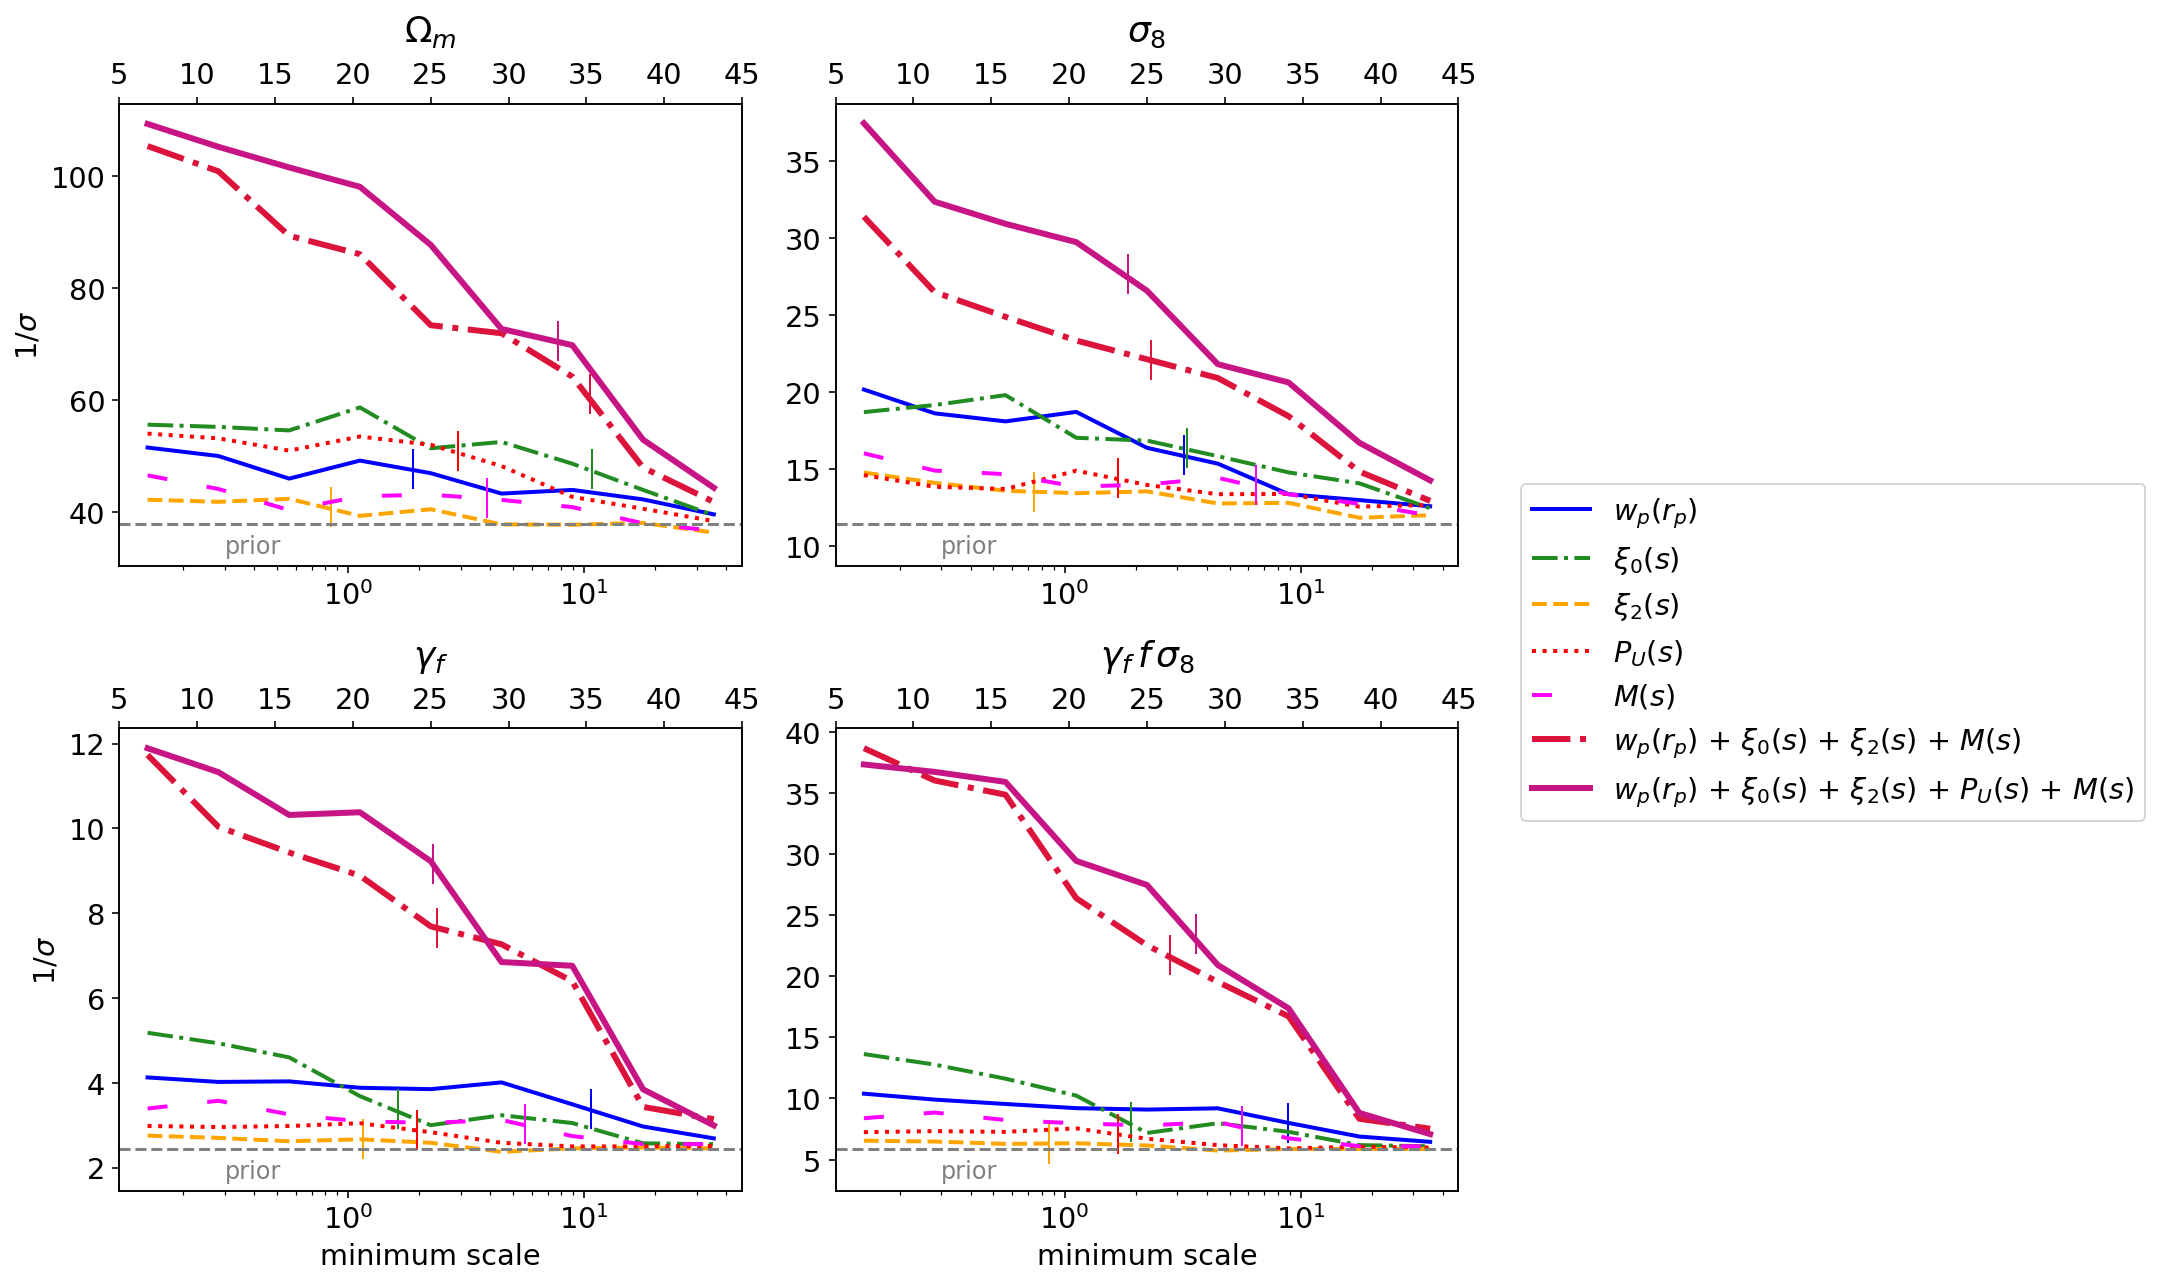

In [42]:
id_pairs = [id_pair]
plotter.plot_scale_dependence_figure(min_scales, results_dicts_minscales, prior_dict, 
                             params_toplot, stat_strs_toplot, id_pairs, labels, colors,
                             lss=lss, lws=lws, xlabel='minimum scale',
                             comparison_dicts=results_dicts_maxscales)

# Appendix

### Figure A1. Contour plots, single model recovery test: a) all cosmological parameters; b) all hod parameters; c) key cosmology + key HOD/AB parameters 

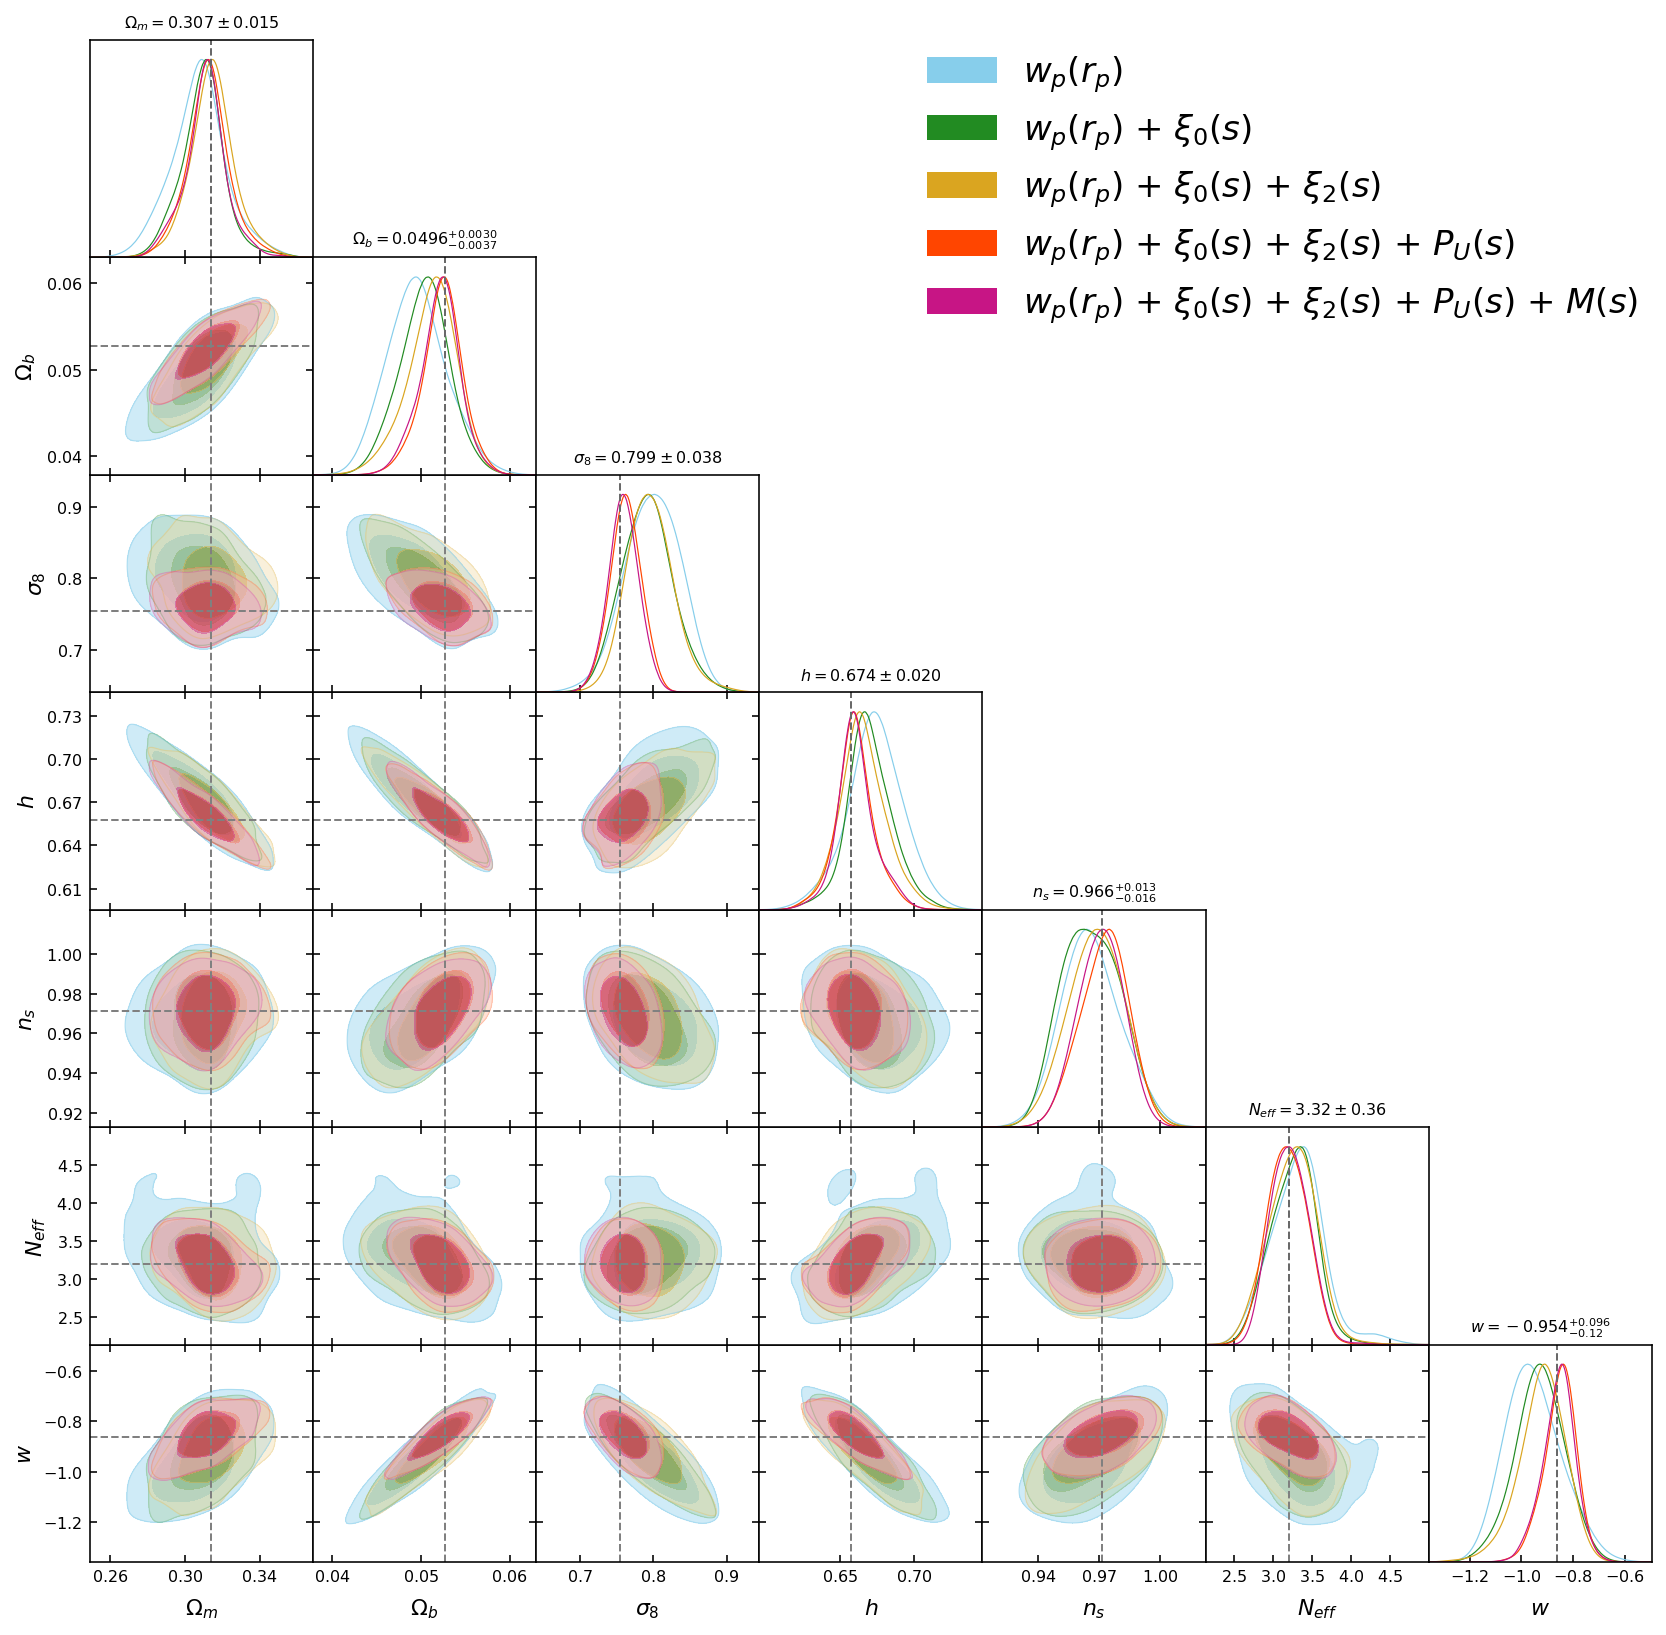

In [7]:
chaintags = [
             'wp_c1h12_all',
             'wp_xi_c1h12_all',
             'wp_xi_xi2_c1h12_all',
             'wp_xi_xi2_upf_c1h12_all',
             'wp_xi_xi2_upf_mcf_c1h12_all',
            ]
legend_labels = [
                 make_label('wp'),
                 make_label(['wp', 'xi']),
                 make_label(['wp', 'xi', 'xi2']),
                 make_label(['wp', 'xi', 'xi2', 'upf']),
                 make_label(['wp', 'xi', 'xi2', 'upf', 'mcf']),
                ]
colors = ['skyblue',
          'forestgreen',
          'goldenrod',
          'orangered',
          'mediumvioletred'
         ]
g = plotter.plot_contours(chaintags, legend_labels=legend_labels,
                          colors=colors, legend_loc='upper right',
                          params_toplot=cosmo_param_names)

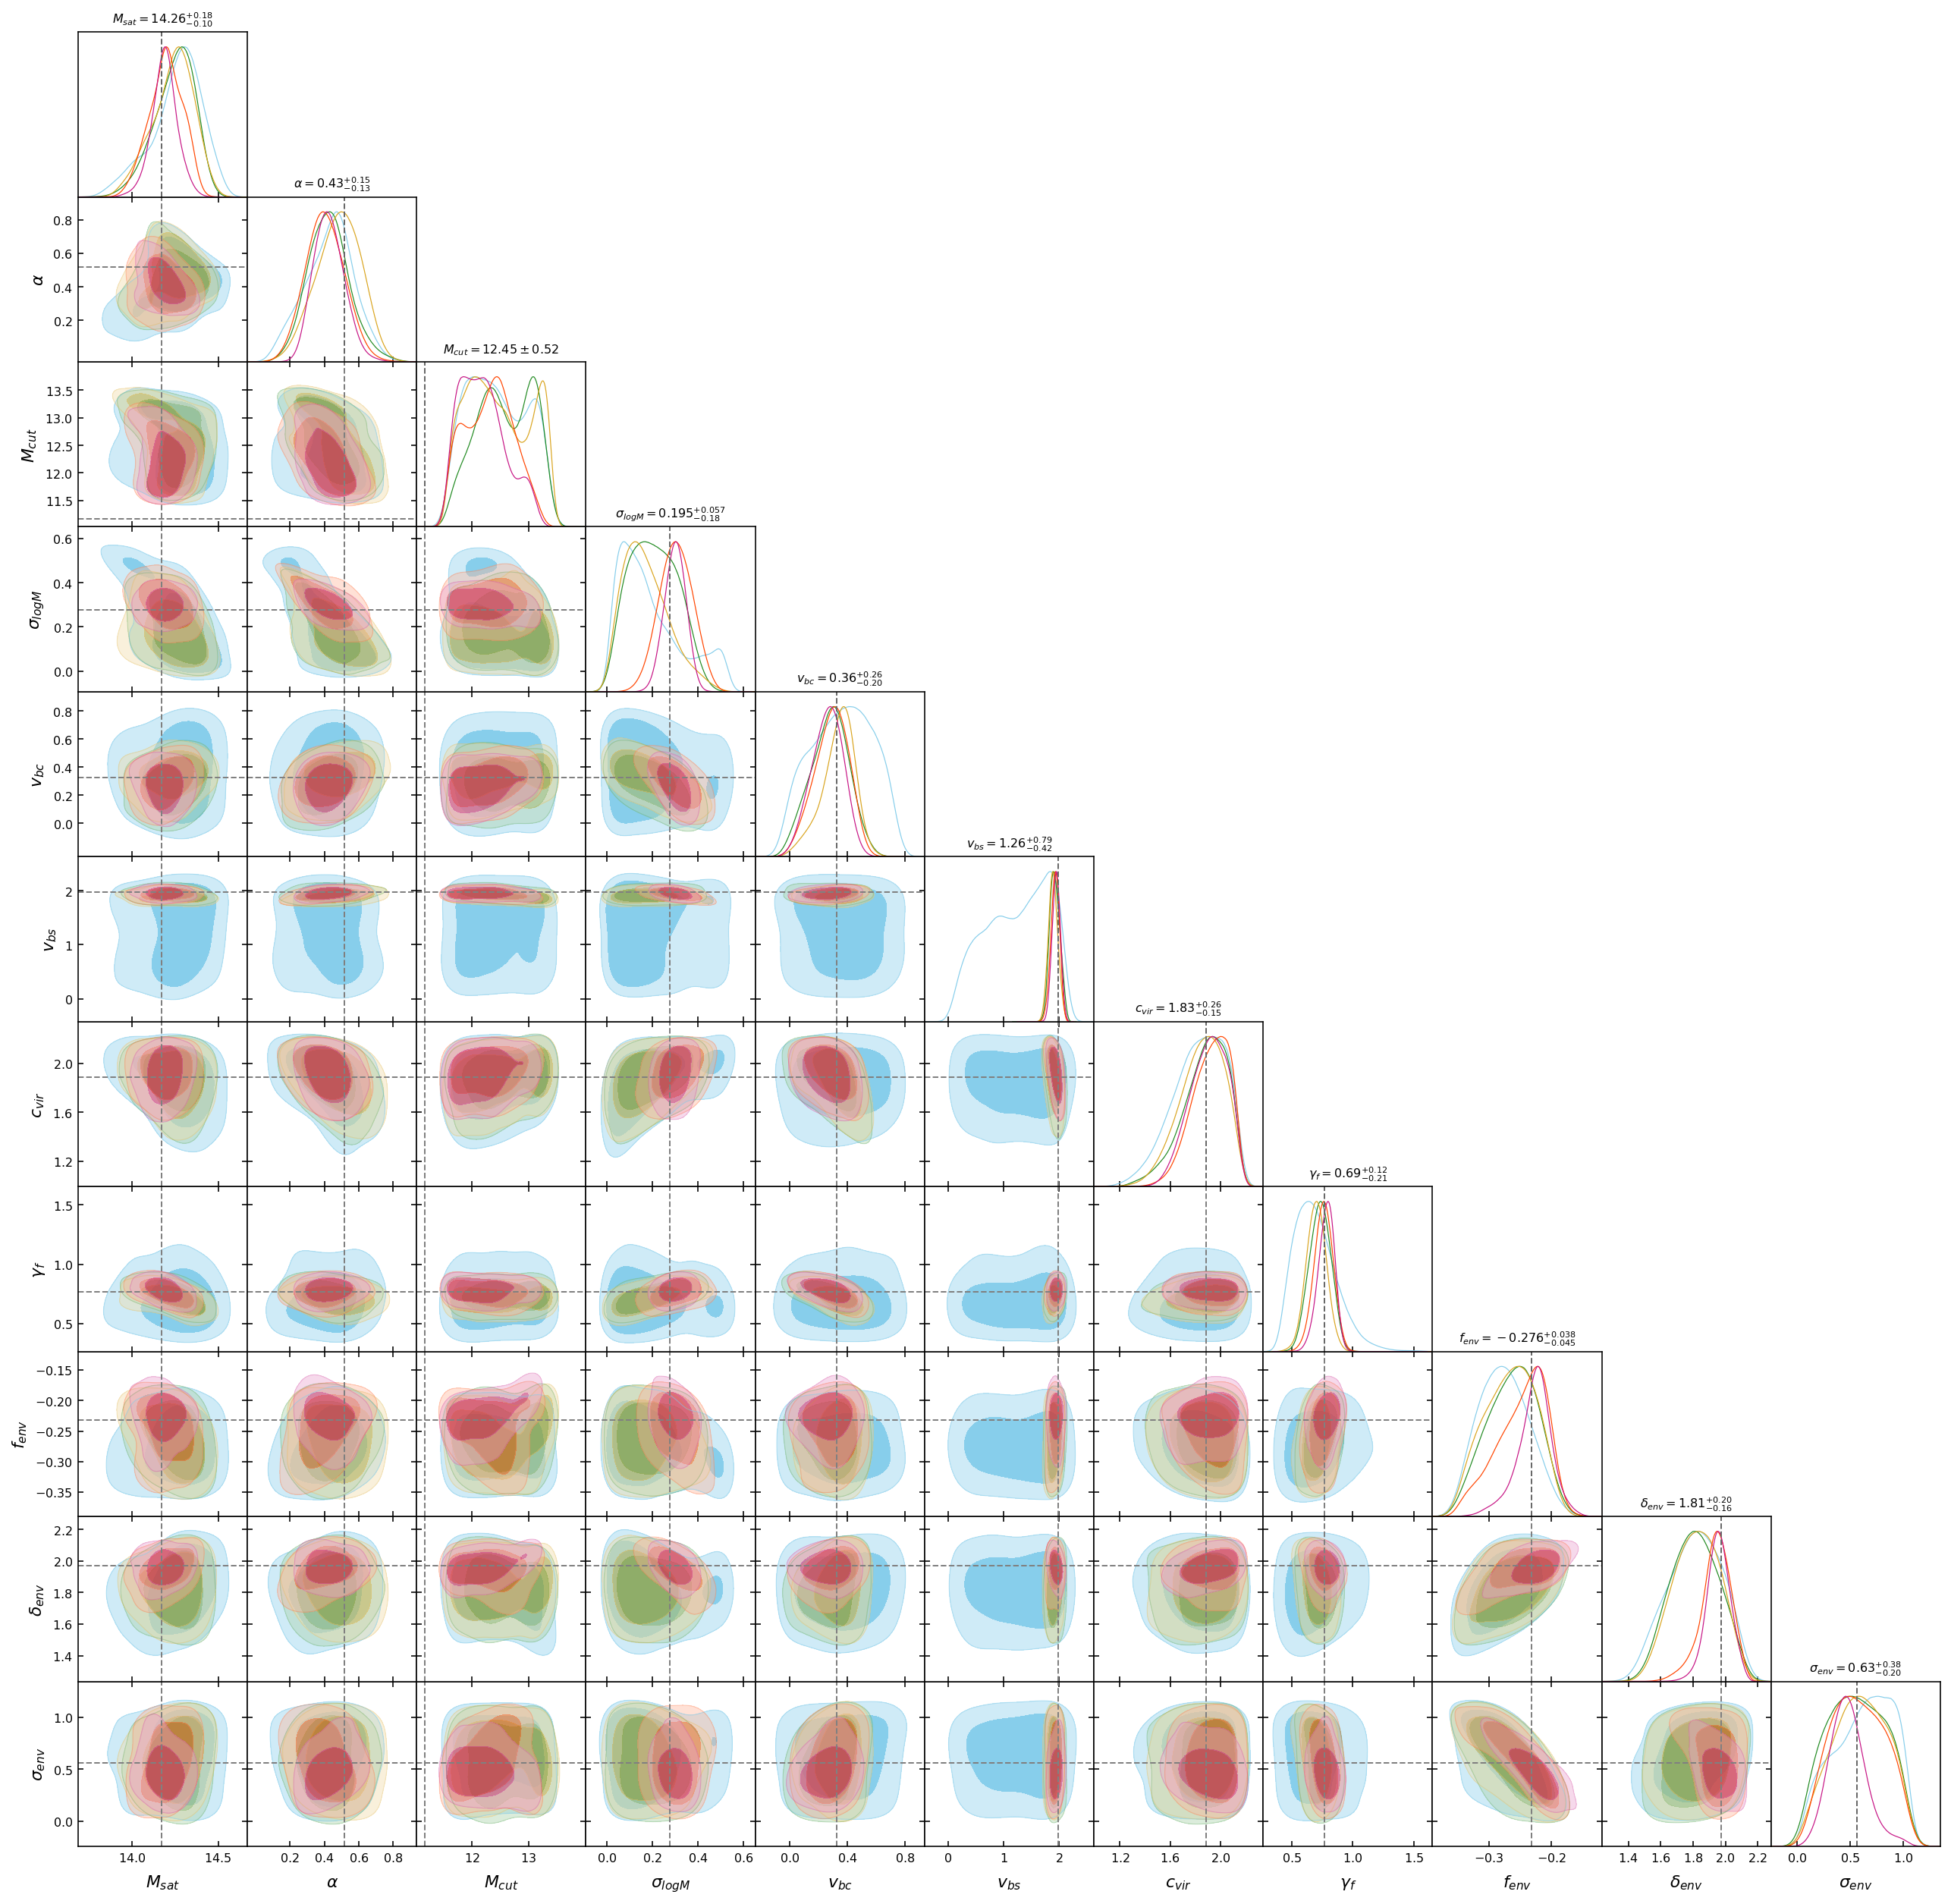

In [6]:
chaintags = [
             'wp_c1h12_all',
             'wp_xi_c1h12_all',
             'wp_xi_xi2_c1h12_all',
             'wp_xi_xi2_upf_c1h12_all',
             'wp_xi_xi2_upf_mcf_c1h12_all',
            ]
colors = ['skyblue',
          'forestgreen',
          'goldenrod',
          'orangered',
          'mediumvioletred'
         ]
g = plotter.plot_contours(chaintags, legend_labels=[],
                          colors=colors, legend_loc='upper right',
                          params_toplot=hod_param_names)

In [8]:
chaintags = [
             'wp_c1h12_all',
             'wp_xi_c1h12_all',
             'wp_xi_xi2_c1h12_all',
             'wp_xi_xi2_upf_c1h12_all',
             'wp_xi_xi2_upf_mcf_c1h12_all',
            ]
colors = ['skyblue',
          'forestgreen',
          'goldenrod',
          'orangered',
          'mediumvioletred'
         ]
g = plotter.plot_contours(chaintags, legend_labels=[],
                          colors=colors, legend_loc='upper right',
                          params_toplot=['Omega_m', 'sigma_8', 'f', 'M_sat', 'v_bs', 'f_env'])

### Figure A2. Contour plot, single model recovery test: for emulator performance & smoothed covariance matrices, key cosmological parameters

TODO: Decide which to show; first is same model as plots above, second is a different model that shows slightly better the messiness of the original covariance matrix

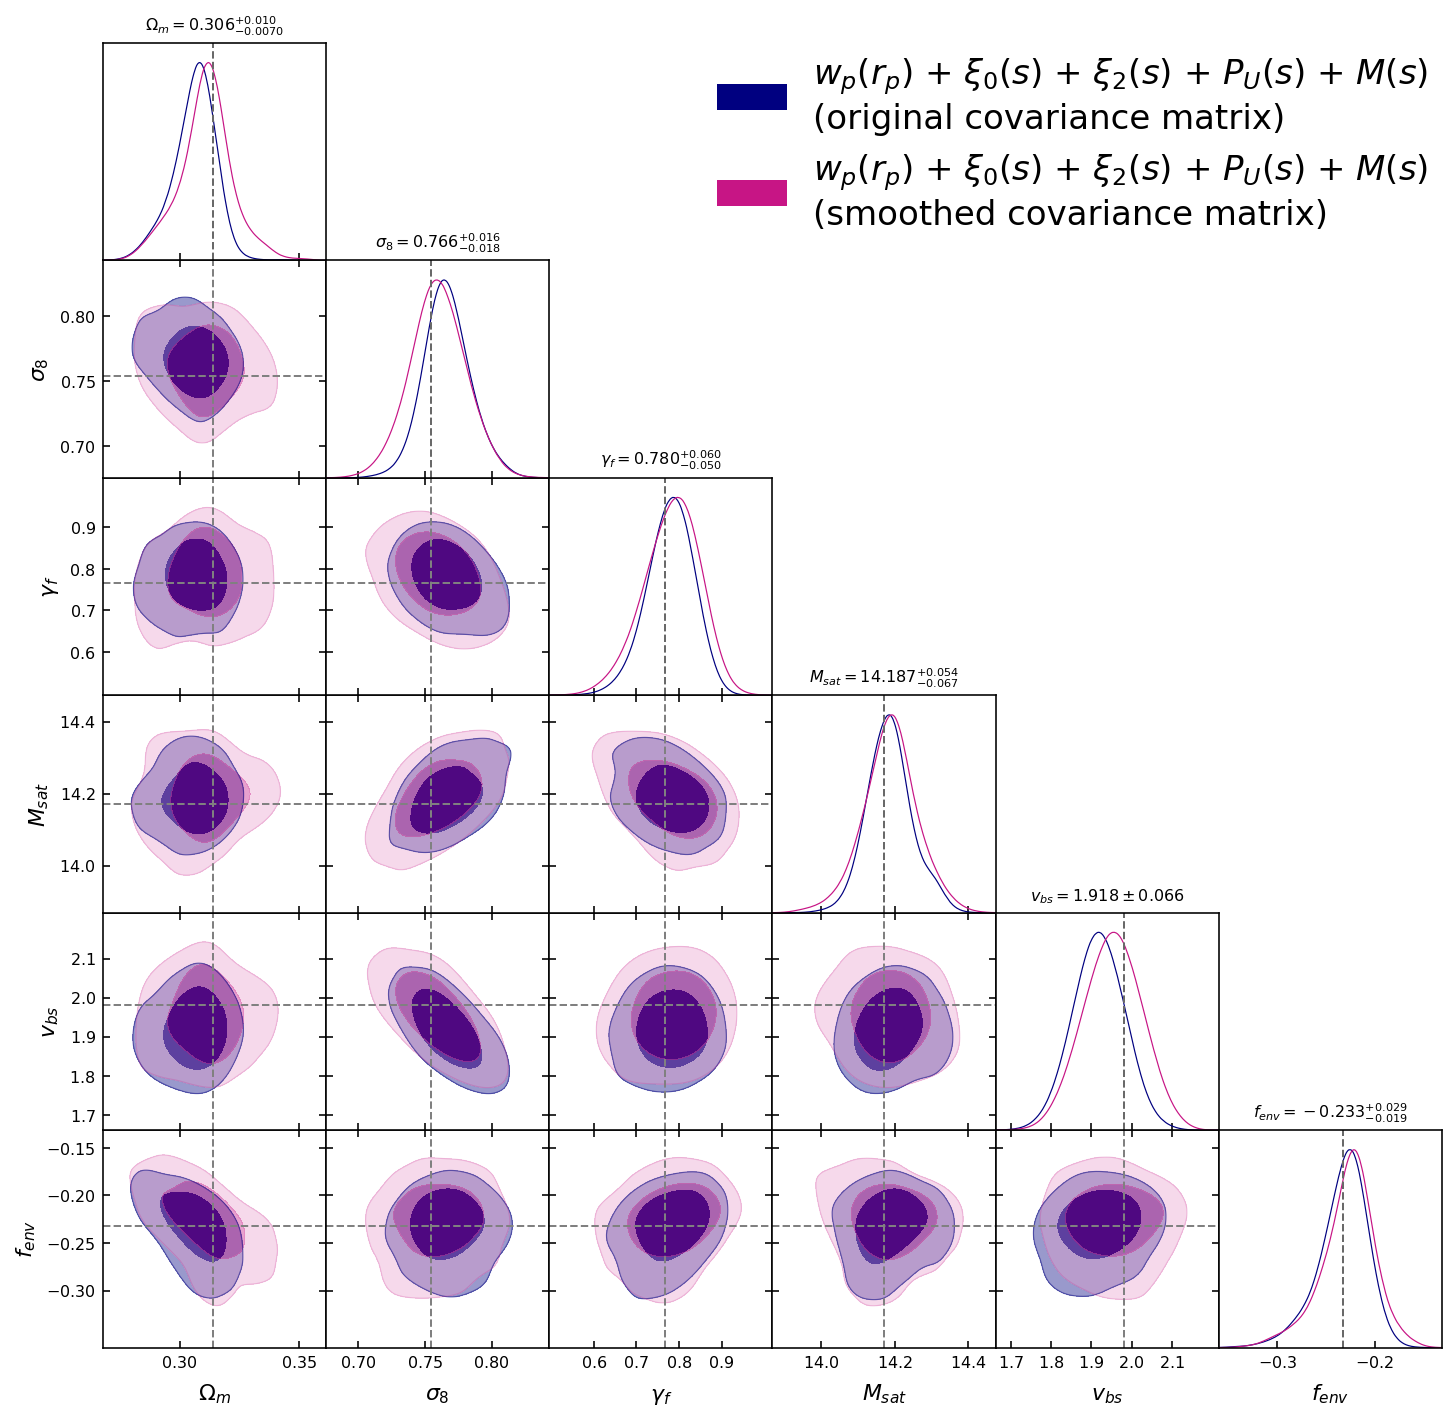

In [10]:
chaintags = [
             'wp_xi_xi2_upf_mcf_c1h12_all_covemuperf',
             'wp_xi_xi2_upf_mcf_c1h12_all',
            ]
colors = ['navy',
          'mediumvioletred'
         ]
legend_labels = [
                 make_label(['wp', 'xi', 'xi2', 'upf', 'mcf']) + '\n(original covariance matrix)',
                 make_label(['wp', 'xi', 'xi2', 'upf', 'mcf']) + '\n(smoothed covariance matrix)',
                ]
g = plotter.plot_contours(chaintags, legend_labels=legend_labels,
                          colors=colors, legend_loc='upper right',
                          params_toplot=['Omega_m', 'sigma_8', 'f', 'M_sat', 'v_bs', 'f_env'])

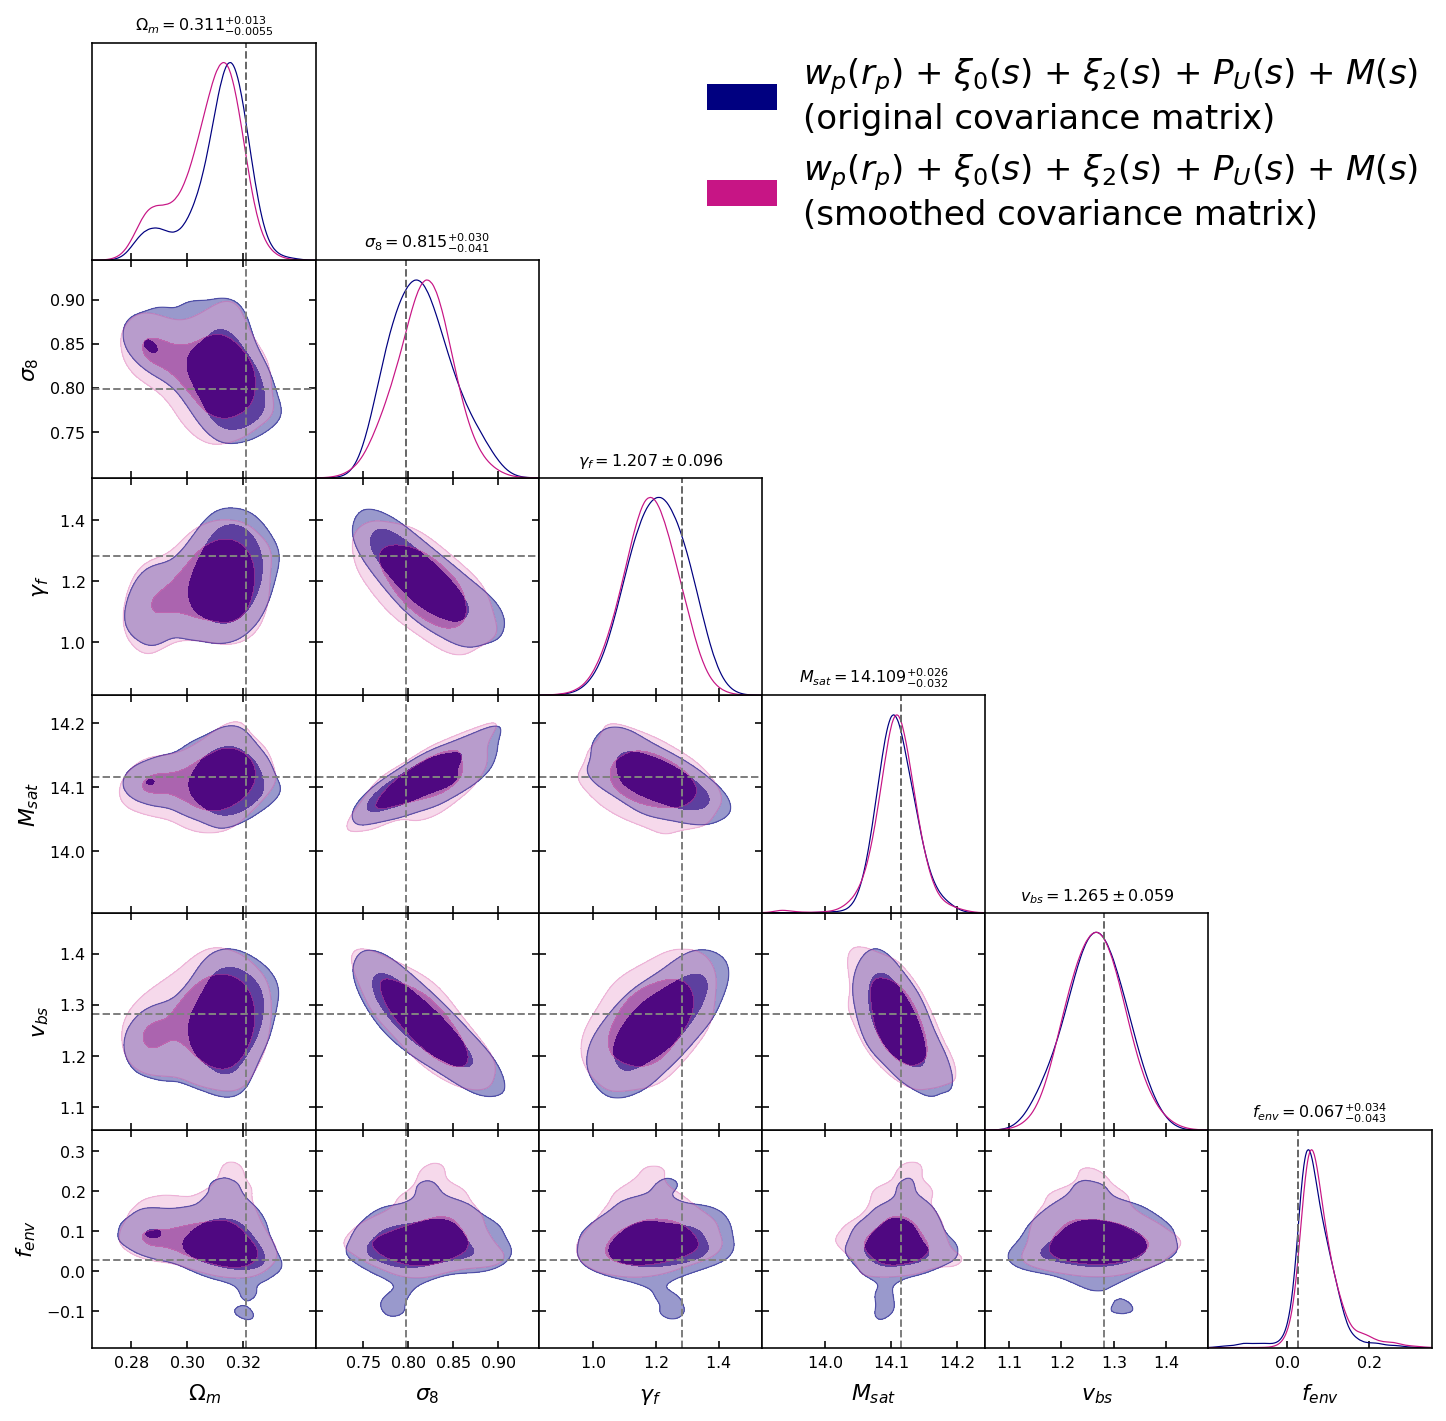

In [11]:
chaintags = [
             'wp_xi_xi2_upf_mcf_c6h62_all_covemuperf',
             'wp_xi_xi2_upf_mcf_c6h62_all_minscale0',
            ]
colors = ['navy',
          'mediumvioletred'
         ]
legend_labels = [
                 make_label(['wp', 'xi', 'xi2', 'upf', 'mcf']) + '\n(original covariance matrix)',
                 make_label(['wp', 'xi', 'xi2', 'upf', 'mcf']) + '\n(smoothed covariance matrix)',
                ]
g = plotter.plot_contours(chaintags, legend_labels=legend_labels,
                          colors=colors, legend_loc='upper right',
                          params_toplot=['Omega_m', 'sigma_8', 'f', 'M_sat', 'v_bs', 'f_env'])

### Figure A3. 70-model recovery test: 1/sigma bar charts for the 3 assembly bias parameters for adding in 1 statistic at a time

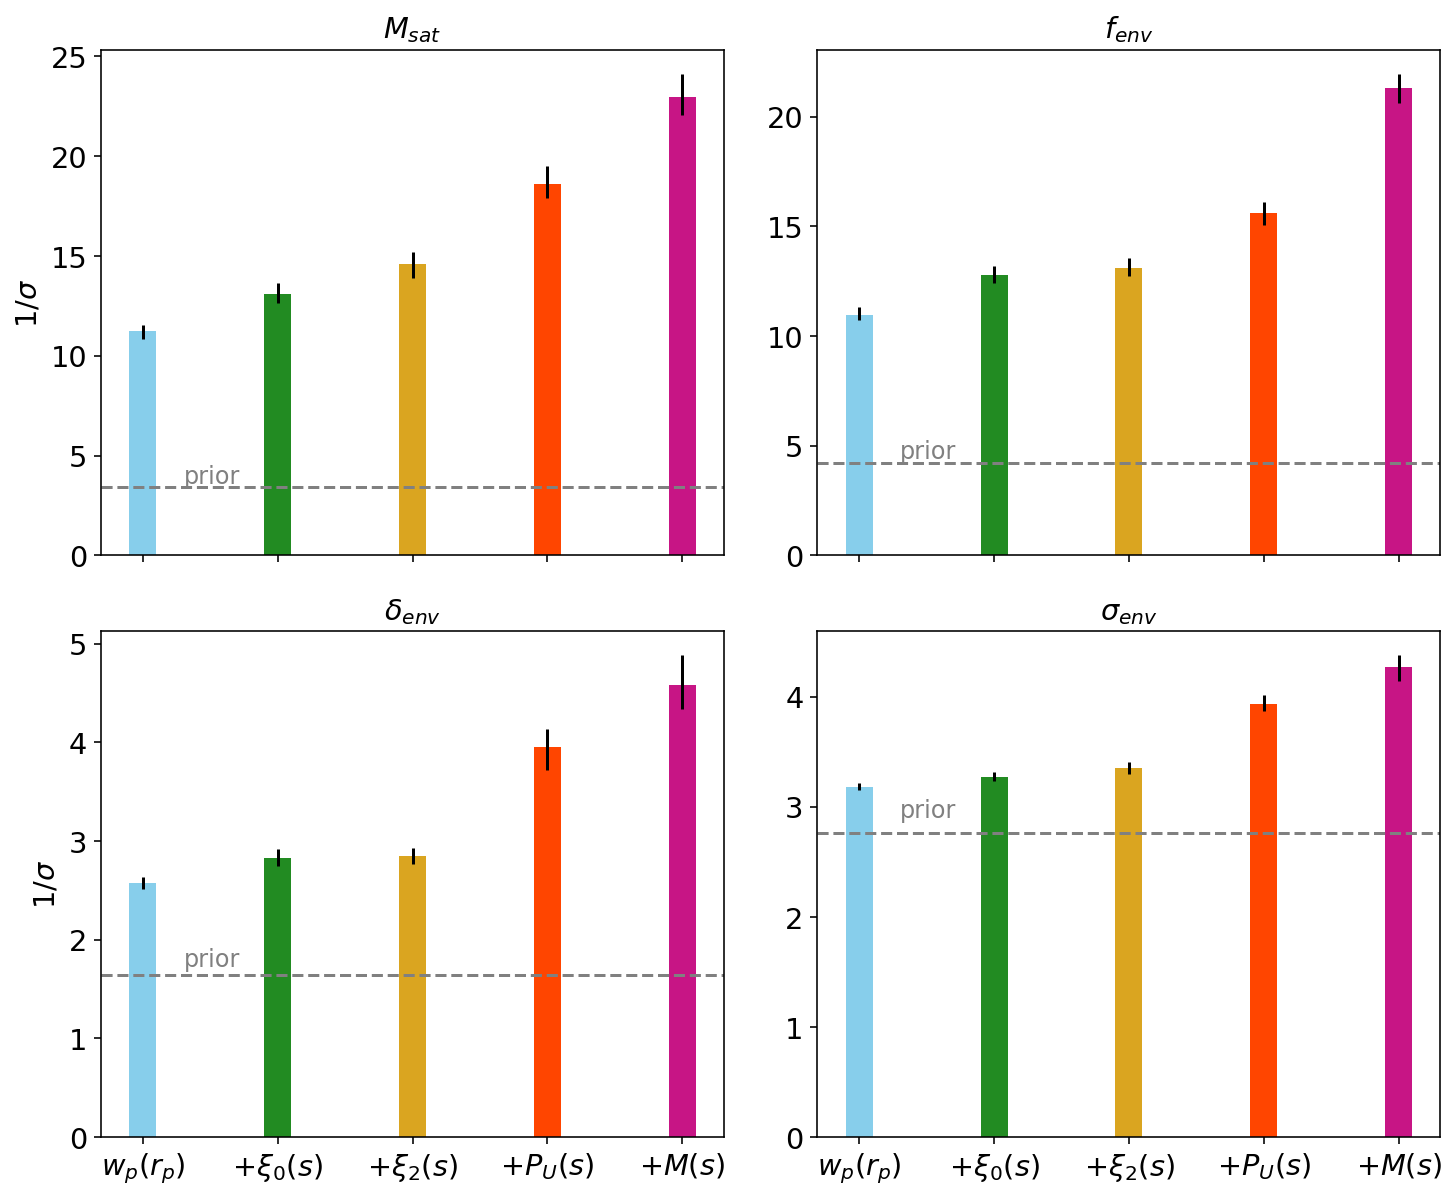

In [16]:
params_toplot = ['M_sat'] + ab_param_names
plotter.plot_uncertainty_figure(results_dict, prior_dict, params_toplot, stat_strs_toplot, 
                                id_pairs, labels, colors)